Image Processing Experiment
Image loaded successfully
Image shape: (1706, 1279, 3)
Image dtype: uint8


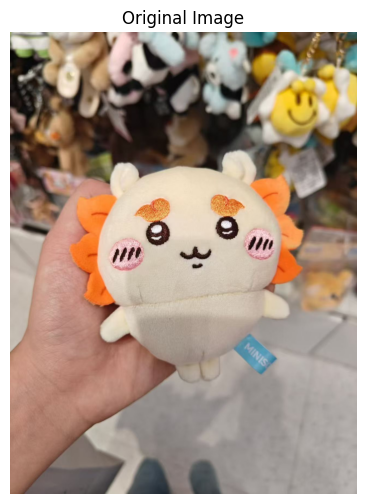

Sobel Filter Processing
Sobel filter completed. Result shape: (1706, 1279)


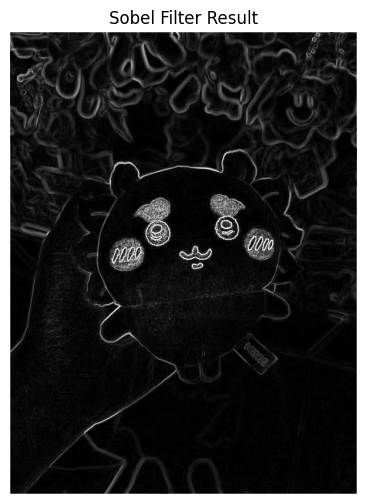

Image saved: output/sobel_filtered.jpg
Custom Kernel Filter Processing
Custom kernel filter completed. Result shape: (1706, 1279, 3)


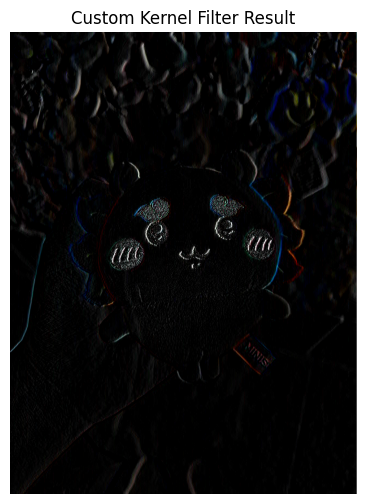

Image saved: output/custom_kernel_filtered.jpg
Color Histogram Calculation


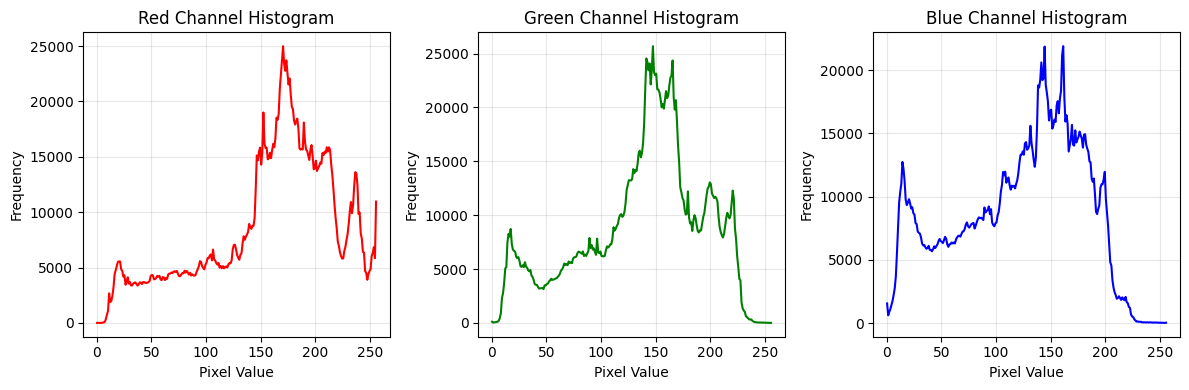

Texture Feature Extraction
Texture Features Extracted:
  contrast: 0.0561
  energy: 0.1729
  homogeneity: 0.9750
  correlation: 0.9903
  entropy: 2.9748


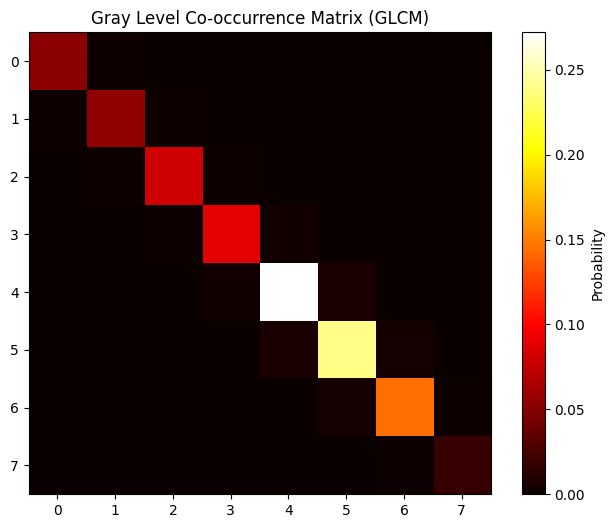


Texture features saved to: output/texture_features.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os



def load_image(image_path):
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        print(f"Image loaded successfully")
        print(f"Image shape: {img_array.shape}")
        print(f"Image dtype: {img_array.dtype}")
        return img_array
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def convolution_2d(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    padded_image = np.zeros((img_height + 2 * pad_height, img_width + 2 * pad_width))
    padded_image[pad_height:pad_height+img_height, pad_width:pad_width+img_width] = image
    output = np.zeros_like(image, dtype=np.float32)
    for i in range(img_height):
        for j in range(img_width):
            window = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(window * kernel)
    return output

#  Sobel
def sobel_filter(image):
    if len(image.shape) == 3:
        gray_image = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
    else:
        gray_image = image.copy()
        
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=np.float32)
    gradient_x = convolution_2d(gray_image, sobel_x)
    gradient_y = convolution_2d(gray_image, sobel_y)
    sobel_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sobel_magnitude = np.clip(sobel_magnitude, 0, 255)
    return sobel_magnitude.astype(np.uint8)


def custom_kernel_filter(image):
    custom_kernel = np.array([[1, 0, -1],
                              [2, 0, -2],
                              [1, 0, -1]], dtype=np.float32)
    filtered_images = []
    if len(image.shape) == 3:
        for channel in range(3):
            channel_image = image[:,:,channel]
            filtered_channel = convolution_2d(channel_image, custom_kernel)
            filtered_channel = np.clip(filtered_channel, 0, 255)
            filtered_images.append(filtered_channel.astype(np.uint8))
        filtered_image = np.stack(filtered_images, axis=-1)
    else:
        filtered_image = convolution_2d(image, custom_kernel)
        filtered_image = np.clip(filtered_image, 0, 255)
        filtered_image = filtered_image.astype(np.uint8)
        filtered_images = [filtered_image]
    
    return filtered_image, filtered_images


def compute_color_histogram(image, bins=256):
    if len(image.shape) == 3:
        channels = ['Red', 'Green', 'Blue']
        histograms = []
        
        for i in range(3):
            channel_data = image[:,:,i].flatten()
            hist, bins_edges = np.histogram(channel_data, bins=bins, range=(0, 256))
            histograms.append(hist)
    else:
        channels = ['Gray']
        gray_data = image.flatten()
        hist, bins_edges = np.histogram(gray_data, bins=bins, range=(0, 256))
        histograms = [hist]
    
    return histograms, bins_edges, channels

def plot_histograms(histograms, bins_edges, channels, image_name):
    plt.figure(figsize=(12, 4))
    
    for i, (hist, channel) in enumerate(zip(histograms, channels)):
        plt.subplot(1, len(channels), i+1)
        bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2
        plt.plot(bin_centers, hist, color=channel.lower() if channel != 'Gray' else 'black')
        plt.title(f'{channel} Channel Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'output/{image_name}_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()


def extract_texture_features(image, distances=[1], angles=[0]):
    if len(image.shape) == 3:
        gray_image = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
    else:
        gray_image = image.copy()
    gray_image = (gray_image / 32).astype(np.uint8)  # 0-7
    
    
    glcm = np.zeros((8, 8), dtype=np.float32)
    
    
    height, width = gray_image.shape
    for i in range(height):
        for j in range(width - 1):  
            pixel1 = gray_image[i, j]
            pixel2 = gray_image[i, j + 1]
            glcm[pixel1, pixel2] += 1
    
    
    if np.sum(glcm) > 0:
        glcm = glcm / np.sum(glcm)
    
    
    features = {}
    
    
    contrast = 0
    for i in range(8):
        for j in range(8):
            contrast += glcm[i, j] * (i - j) ** 2
    features['contrast'] = contrast
    
    
    energy = np.sum(glcm ** 2)
    features['energy'] = energy
    
    
    homogeneity = 0
    for i in range(8):
        for j in range(8):
            homogeneity += glcm[i, j] / (1 + abs(i - j))
    features['homogeneity'] = homogeneity
    
    
    mean_i = np.sum([i * np.sum(glcm[i, :]) for i in range(8)])
    mean_j = np.sum([j * np.sum(glcm[:, j]) for j in range(8)])
    
    std_i = np.sqrt(np.sum([((i - mean_i) ** 2) * np.sum(glcm[i, :]) for i in range(8)]))
    std_j = np.sqrt(np.sum([((j - mean_j) ** 2) * np.sum(glcm[:, j]) for j in range(8)]))
    
    correlation = 0
    if std_i > 0 and std_j > 0:
        for i in range(8):
            for j in range(8):
                correlation += ((i - mean_i) * (j - mean_j) * glcm[i, j]) / (std_i * std_j)
    features['correlation'] = correlation
    
    
    entropy = 0
    for i in range(8):
        for j in range(8):
            if glcm[i, j] > 0:
                entropy -= glcm[i, j] * np.log2(glcm[i, j])
    features['entropy'] = entropy
    
    return features, glcm

def save_image(image, filename):
    img = Image.fromarray(image)
    img.save(filename)
    print(f"Image saved: {filename}")


def main():
    print("Image Processing Experiment")    
    image_path = 'shisa.jpg'  
    if not os.path.exists(image_path):
        print("Input image not found. Creating a sample image...")
        sample_image = np.zeros((256, 256, 3), dtype=np.uint8)
        for i in range(256):
            for j in range(256):
                sample_image[i, j, 0] = (i + j) % 256  # R
                sample_image[i, j, 1] = i  # G
                sample_image[i, j, 2] = j  # B
        save_image(sample_image, 'input_image.jpg')
        image_array = sample_image
        print("Sample image created and saved as 'input_image.jpg'")
    else:
        image_array = load_image(image_path)
    
    if image_array is None:
        print("Failed to load")
        return
    
    plt.figure(figsize=(8, 6))
    if len(image_array.shape) == 3:
        plt.imshow(image_array)
    else:
        plt.imshow(image_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.savefig('output/original_image.png', dpi=150, bbox_inches='tight')
    plt.show()
    

    print("Sobel Filter Processing")
   
    
    sobel_result = sobel_filter(image_array)
    print(f"Sobel filter completed. Result shape: {sobel_result.shape}")
    
    plt.figure(figsize=(8, 6))
    plt.imshow(sobel_result, cmap='gray')
    plt.title('Sobel Filter Result')
    plt.axis('off')
    plt.savefig('output/sobel_filtered.png', dpi=150, bbox_inches='tight')
    plt.show()
    save_image(sobel_result, 'output/sobel_filtered.jpg')
    
    print("Custom Kernel Filter Processing")
    
    custom_result, channel_results = custom_kernel_filter(image_array)
    print(f"Custom kernel filter completed. Result shape: {custom_result.shape}")

    plt.figure(figsize=(8, 6))
    if len(custom_result.shape) == 3:
        plt.imshow(custom_result)
    else:
        plt.imshow(custom_result, cmap='gray')
    plt.title('Custom Kernel Filter Result')
    plt.axis('off')
    plt.savefig('output/custom_kernel_filtered.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    save_image(custom_result, 'output/custom_kernel_filtered.jpg')
    

    print("Color Histogram Calculation")

    histograms, bins_edges, channels = compute_color_histogram(image_array)
    plot_histograms(histograms, bins_edges, channels, 'original')
    
    
    print("Texture Feature Extraction")
    texture_features, glcm = extract_texture_features(image_array)
    
    print("Texture Features Extracted:")
    for feature_name, feature_value in texture_features.items():
        print(f"  {feature_name}: {feature_value:.4f}")
        
    plt.figure(figsize=(8, 6))
    plt.imshow(glcm, cmap='hot', interpolation='nearest')
    plt.title('Gray Level Co-occurrence Matrix (GLCM)')
    plt.colorbar(label='Probability')
    plt.savefig('output/glcm_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    np.save('output/texture_features.npy', texture_features)
    print("\nTexture features saved to: output/texture_features.npy")

if __name__ == "__main__":
    main()